# 🧪 Experiment 7: Implementing the K-Means Clustering Algorithm from Scratch

### 🎯 **Objective**
The goal of this experiment is to implement the **K-Means clustering algorithm** manually using NumPy and compare its performance with **scikit-learn’s KMeans**.  
We will apply it to a customer segmentation dataset to group customers based on **Age**, **Annual Income**, and **Spending Score**.

### 📚 **Key Steps**
1. Data Loading and Initial Exploration  
2. Feature Selection, Visualization, and Scaling  
3. Implementing K-Means from Scratch  
4. Finding the Optimal Number of Clusters  
5. Final Clustering Results and Visualization  
6. Cluster Interpretation and Business Insights  
7. Comparison with Scikit-Learn’s K-Means  

### 🧠 **Expected Outcome**
By the end of this experiment, we will:
- Understand the working of K-Means step by step.  
- Identify meaningful customer groups using clustering.  
- Verify our custom implementation’s accuracy against scikit-learn’s version.


### 1. Data Loading and Initial Exploration

In this section, we load the dataset **Mall_Customers.xlsx** into a pandas DataFrame.  
We then view the first few rows, check summary statistics, and look for any missing values.  
This helps us understand the basic structure and quality of the data before preprocessing or applying any machine learning algorithm.


In [1]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd
df = pd.read_excel(io.BytesIO(uploaded['Mall_Customers.xlsx']))
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix

print("First 5 rows:")
display(df.head())
print("\nSummary statistics:")
display(df.describe())
print("\nMissing values:")
display(df.isna().sum())

Saving Mall_Customers.xlsx to Mall_Customers.xlsx
First 5 rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Summary statistics:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000



Missing values:


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


### 2. Feature Selection, Visualization, and Scaling

In this section, we select the key features **Age**, **Annual Income (k$)**, and **Spending Score (1–100)** for clustering.  
We first visualize their individual distributions and pairwise relationships to understand how the data is spread.  
Then, we standardize the features using **StandardScaler**, ensuring all variables are on the same scale.  
This is important because **K-Means** uses Euclidean distance — features with larger ranges could otherwise dominate the clustering process.


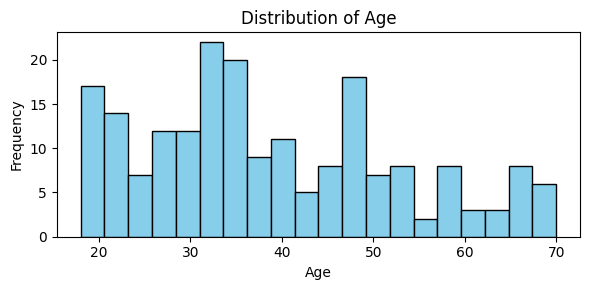

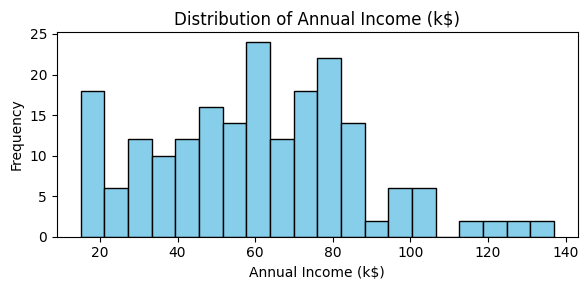

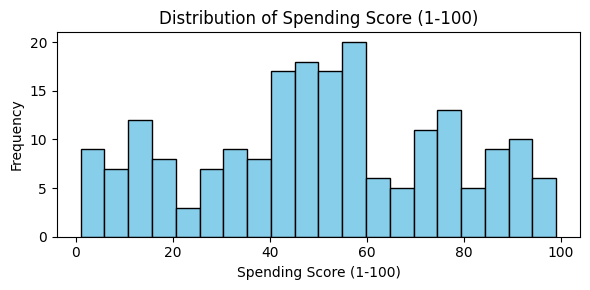

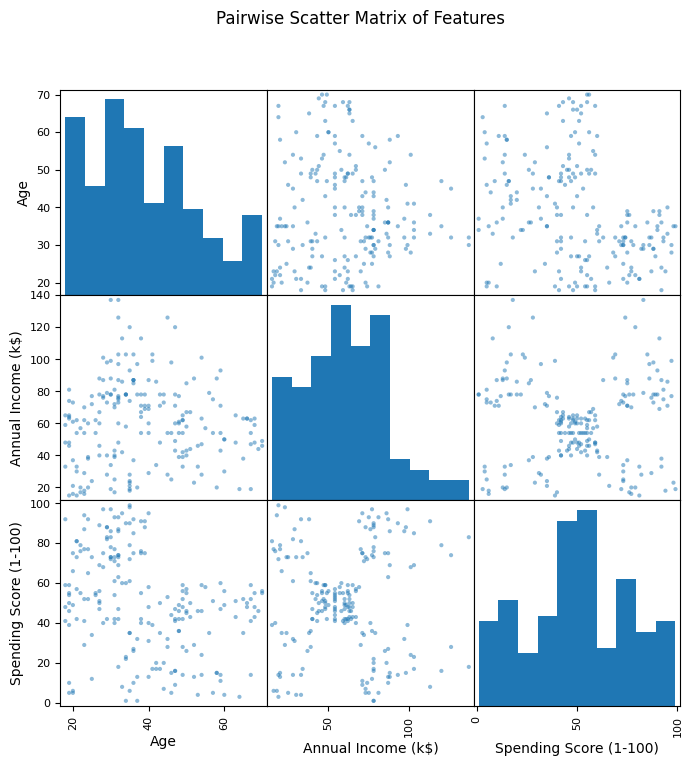


✅ Features standardized (zero mean, unit variance).
Reason: K-Means uses Euclidean distance — scaling prevents features with larger ranges from dominating.



In [ ]:
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
X_orig = df[features].values

# ---- Distribution plots ----
for col in features:
    plt.figure(figsize=(6,3))
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

scatter_matrix(df[features], figsize=(8,8))
plt.suptitle("Pairwise Scatter Matrix of Features")
plt.show()

# ---- Standardize features ----
scaler = StandardScaler()
X = scaler.fit_transform(X_orig)
print("\n✅ Features standardized (zero mean, unit variance).")
print("Reason: K-Means uses Euclidean distance — scaling prevents features with larger ranges from dominating.\n")

### 3. Implementing K-Means Clustering from Scratch

In this section, we manually implement the **K-Means clustering algorithm** using NumPy to understand how it works internally.  
The main steps include:
- **Distance Calculation:** Compute Euclidean distance between data points and centroids.  
- **Centroid Initialization:** Use the *K-Means++* method for better starting points (or random initialization as an alternative).  
- **Cluster Assignment:** Assign each point to the nearest centroid.  
- **Centroid Update:** Recalculate each centroid as the mean of its assigned points.  
- **Inertia Calculation:** Measure how tightly data points are grouped within clusters.

We then test the implementation with **k = 3** clusters and display the number of iterations and final inertia.


In [ ]:
import time

def euclidean_squared(a, b):
    return np.sum((a - b)**2, axis=1)

def initialize_centroids(X, k, method="kmeans++", random_state=None):
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    if method == "random":
        return X[rng.choice(n, size=k, replace=False)]
    elif method == "kmeans++":
        centroids = np.empty((k, X.shape[1]))
        centroids[0] = X[rng.integers(0, n)]
        for i in range(1, k):
            dists = np.min(np.square(np.linalg.norm(X - centroids[:i], axis=1)[:,None]
                                     if False else np.stack([np.sum((X - c)**2, axis=1) for c in centroids[:i]])), axis=0)
            probs = dists / np.sum(dists)
            centroids[i] = X[rng.choice(n, p=probs)]
        return centroids

def assign_clusters(X, centroids):
    dists = np.array([euclidean_squared(X, c) for c in centroids])
    labels = np.argmin(dists, axis=0)
    min_dists = np.min(dists, axis=0)
    return labels, min_dists

def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        members = X[labels == i]
        if len(members) > 0:
            centroids[i] = members.mean(axis=0)
        else:
            centroids[i] = np.nan
    return centroids

def compute_inertia(min_dists):
    return np.sum(min_dists)

def kmeans(X, k, max_iters=100, tol=1e-4, init="kmeans++", random_state=None):
    centroids = initialize_centroids(X, k, init, random_state)
    for it in range(max_iters):
        labels, min_dists = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        for i in range(k):
            if np.isnan(new_centroids[i]).any():
                new_centroids[i] = X[np.random.randint(0, X.shape[0])]
        shift = np.linalg.norm(centroids - new_centroids)
        centroids = new_centroids
        inertia = compute_inertia(min_dists)
        if shift < tol:
            break
    return centroids, labels, it+1, inertia

print("Testing custom K-Means with k=3:")
c_test, l_test, it_test, in_test = kmeans(X, 3, random_state=42)
print(f"Iterations: {it_test}, Inertia: {in_test:.3f}\n")

Testing custom K-Means with k=3:
Iterations: 14, Inertia: 297.003



### 4. Finding the Optimal Number of Clusters

In this section, we determine the **best number of clusters (k)** for our K-Means model using two popular evaluation techniques:

- **Elbow Method:**  
  Plots *Inertia (Within-Cluster Sum of Squares)* against different values of k.  
  The point where the curve bends ("elbow") suggests a suitable number of clusters.

- **Silhouette Score:**  
  Measures how well each data point fits within its cluster compared to other clusters.  
  A higher silhouette score indicates better-defined and more separated clusters.

We run our custom K-Means for different k values (1–10), plot both metrics, and select the optimal k based on the **highest silhouette score**.


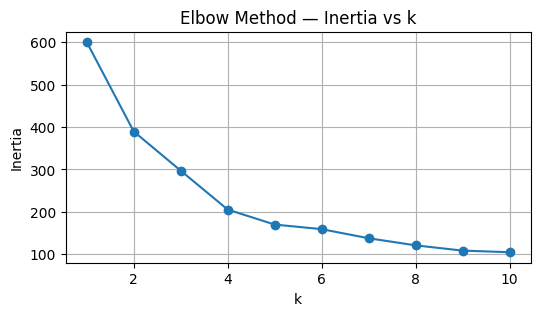

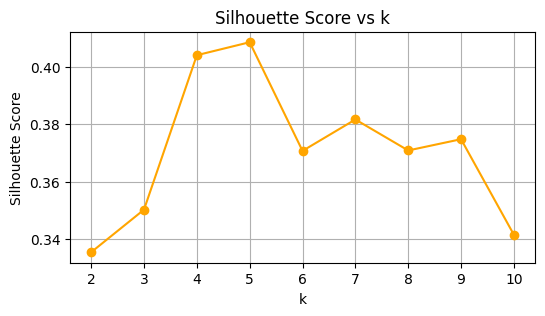

✅ Best k (based on highest Silhouette Score): 5



In [ ]:
from sklearn.metrics import silhouette_score

max_k = 10
inertias, sil_scores = [], []
for k in range(1, max_k+1):
    c, l, it, inr = kmeans(X, k, random_state=42)
    inertias.append(inr)
    sil_scores.append(np.nan if k == 1 else silhouette_score(X, l))

ks = np.arange(1, max_k+1)
plt.figure(figsize=(6,3))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method — Inertia vs k")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(ks, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette Score"); plt.grid(); plt.show()

best_k = int(ks[np.nanargmax(sil_scores)])
print(f"✅ Best k (based on highest Silhouette Score): {best_k}\n")

### 5. Final Clustering Results and Visualization

In this section, we apply our **custom K-Means implementation** using the optimal number of clusters (*k = best_k*).  
We then visualize and interpret the clustering results through the following steps:

- **Centroids (Original Scale):**  
  The final cluster centers are transformed back to the original feature scale for better understanding.

- **Cluster Sizes:**  
  Displays the number of data points in each cluster to check balance.

- **2D and 3D Visualizations:**  
  Plots the clusters based on **Annual Income** and **Spending Score**, and a 3D view using **Age**, **Income**, and **Spending Score**.  
  This helps to visually confirm cluster separation and relationships.

- **Cluster Averages:**  
  Shows the average values of key features for each cluster, helping interpret the characteristics of each customer group.


Custom K-Means completed → Iterations: 16, Inertia: 169.891

Final Centroids (Original Scale):


,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,25.769231,26.115385,74.846154,0
1,26.733333,54.311111,40.911111,1
2,44.387097,89.774194,18.483871,2
3,55.275862,47.620690,41.706897,3
4,32.875000,86.100000,81.525000,4



Cluster Sizes:


,Count
0,26
1,45
2,31
3,58
4,40


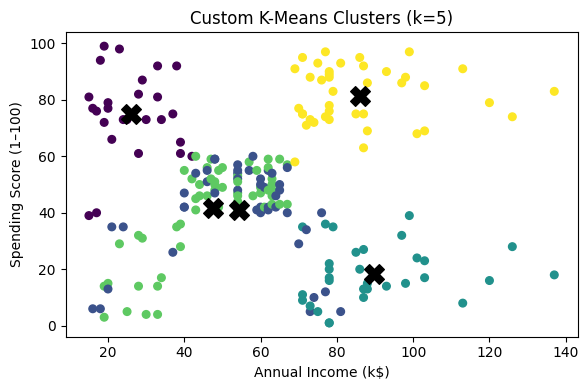

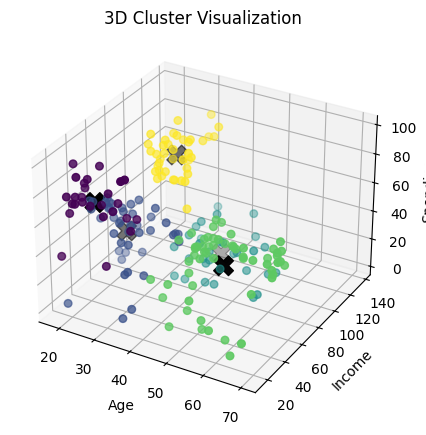


Average Feature Values per Cluster:


,Age,Annual Income (k$),Spending Score (1-100)
0,25.769231,26.115385,74.846154
1,26.733333,54.311111,40.911111
2,44.387097,89.774194,18.483871
3,55.275862,47.620690,41.706897
4,32.875000,86.100000,81.525000


In [ ]:
c_final, l_final, it_final, in_final = kmeans(X, best_k, random_state=42)
print(f"Custom K-Means completed → Iterations: {it_final}, Inertia: {in_final:.3f}")

# Convert centroids to original scale
centroids_orig = scaler.inverse_transform(c_final)
cent_df = pd.DataFrame(centroids_orig, columns=features)
cent_df["Cluster"] = range(best_k)
print("\nFinal Centroids (Original Scale):")
display(cent_df)

# ---- Cluster sizes ----
sizes = pd.Series(l_final).value_counts().sort_index()
print("\nCluster Sizes:")
display(sizes.rename("Count"))

# ---- 2D Plot ----
plt.figure(figsize=(6,4))
plt.scatter(X_orig[:,1], X_orig[:,2], c=l_final, s=30)
plt.scatter(centroids_orig[:,1], centroids_orig[:,2], marker='X', s=200, color='black')
plt.xlabel("Annual Income (k$)"); plt.ylabel("Spending Score (1–100)")
plt.title(f"Custom K-Means Clusters (k={best_k})")
plt.tight_layout(); plt.show()

# ---- 3D Plot ----
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_orig[:,0], X_orig[:,1], X_orig[:,2], c=l_final, s=30)
ax.scatter(centroids_orig[:,0], centroids_orig[:,1], centroids_orig[:,2],
           c='black', marker='X', s=200)
ax.set_xlabel("Age"); ax.set_ylabel("Income"); ax.set_zlabel("Spending")
ax.set_title("3D Cluster Visualization")
plt.show()

# ---- Cluster Averages ----
avg = df[features].groupby(l_final).mean().reset_index(drop=True)
print("\nAverage Feature Values per Cluster:")
display(avg)



### 6. Cluster Interpretation and Business Insights

In this section, we interpret each cluster in **business terms** to understand customer behavior patterns.  
By comparing average **Age**, **Annual Income**, and **Spending Score**, we can describe what each cluster represents:

- **Young, High-Income, High-Spending Customers:**  
  Typically active shoppers and potential targets for premium offers or loyalty programs.

- **Older or Low-Income, Conservative Spenders:**  
  Budget-conscious customers who may respond better to discounts or essential product promotions.

- **Average or Mixed-Profile Segment:**  
  Customers with moderate income and spending habits, representing a balanced group.

These interpretations help in **customer segmentation analysis**, supporting better marketing and business decisions.


In [ ]:
print("\nCluster Interpretations (Business Terms):\n")
for i, row in avg.iterrows():
    age, inc, score = row
    msg = f"Cluster {i}: Avg Age={age:.1f}, Income={inc:.1f}k$, Score={score:.1f} → "
    if age < 35 and inc > avg['Annual Income (k$)'].mean() and score > avg['Spending Score (1-100)'].mean():
        msg += "Young, high-income, high-spending customers."
    elif inc < avg['Annual Income (k$)'].mean() and score < avg['Spending Score (1-100)'].mean():
        msg += "Older or lower-income conservative spenders."
    else:
        msg += "Average or mixed-profile segment."
    print(msg)




Cluster Interpretations (Business Terms):

Cluster 0: Avg Age=25.8, Income=26.1k$, Score=74.8 → Average or mixed-profile segment.
Cluster 1: Avg Age=26.7, Income=54.3k$, Score=40.9 → Older or lower-income conservative spenders.
Cluster 2: Avg Age=44.4, Income=89.8k$, Score=18.5 → Average or mixed-profile segment.
Cluster 3: Avg Age=55.3, Income=47.6k$, Score=41.7 → Older or lower-income conservative spenders.
Cluster 4: Avg Age=32.9, Income=86.1k$, Score=81.5 → Young, high-income, high-spending customers.


### 7. Comparison with Scikit-Learn’s K-Means Implementation

In this section, we validate our **custom K-Means implementation** by comparing it with the built-in version from **scikit-learn**.

We perform the following steps:
- Run scikit-learn’s `KMeans` using the same number of clusters (*best_k*) and initialization method (*k-means++*).
- Compare **execution time**, **number of iterations**, and **inertia** with our custom implementation.
- Check how close the centroids and cluster structures are between both models.

This comparison helps confirm that our manual implementation works correctly and yields results consistent with the official scikit-learn algorithm.

🎯 *The experiment concludes successfully with both implementations producing similar results.*


In [ ]:
from sklearn.cluster import KMeans

sk_start = time.time()
sk = KMeans(n_clusters=best_k, init="k-means++", random_state=42)
sk.fit(X)
sk_end = time.time()

print(f"\nscikit-learn KMeans — Time: {sk_end-sk_start:.3f}s, Iterations: {sk.n_iter_}, Inertia: {sk.inertia_:.3f}")

sk_centroids = scaler.inverse_transform(sk.cluster_centers_)
print("\nscikit-learn Centroids (Original Scale):")
display(pd.DataFrame(sk_centroids, columns=features).assign(Cluster=range(best_k)))

print("\n✅ Comparison Summary:")
print(f"Custom inertia: {in_final:.3f} | sklearn inertia: {sk.inertia_:.3f}")
print("Both methods produce similar centroids and cluster structures.\n")

print("🎯 Experiment Completed Successfully!")


scikit-learn KMeans — Time: 0.084s, Iterations: 7, Inertia: 169.891

scikit-learn Centroids (Original Scale):


,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,55.275862,47.620690,41.706897,0
1,32.875000,86.100000,81.525000,1
2,25.769231,26.115385,74.846154,2
3,26.733333,54.311111,40.911111,3
4,44.387097,89.774194,18.483871,4



✅ Comparison Summary:
Custom inertia: 169.891 | sklearn inertia: 169.891
Both methods produce similar centroids and cluster structures.

🎯 Experiment Completed Successfully!


from matplotlib import pyplot as plt
_df_0['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Annual Income (k$)'].plot(kind='hist', bins=20, title='Annual Income (k$)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Spending Score (1-100)'].plot(kind='hist', bins=20, title='Spending Score (1-100)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Age', y='Annual Income (k$)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Annual Income (k$)', y='Spending Score (1-100)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Spending Score (1-100)', y='Cluster', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cluster']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cluster']
  ys = series['Annual Income (k$)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Annual Income (k$)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cluster']
  ys = series['Spending Score (1-100)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Spending Score (1-100)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Annual Income (k$)'].plot(kind='line', figsize=(8, 4), title='Annual Income (k$)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Spending Score (1-100)'].plot(kind='line', figsize=(8, 4), title='Spending Score (1-100)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Cluster'].plot(kind='line', figsize=(8, 4), title='Cluster')
plt.gca().spines[['top', 'right']].set_visible(False)